# Masks
In the following notebook we analyze random masks extracted from several smartcards performing elliptic curve crypto. We extracted the masks using the "Test n + \epsilon" from the [ECTester paper](https://pyecsca.org/_static/ectester_ches25.pdf).

See the overview of the data collection below.

![](overview.svg)

In [20]:
import os
from math import ceil
import matplotlib.pyplot as plt

def get_masks(filepath):
    with open(filepath) as f:
        masks = [m.strip() for m in f.readlines()]
    masks = [int(m,16) for m in masks]
    return masks

def get_masks_info(filepath):
    # Returns a list of [mask,scalar,n,epsilon]. Here n is the real order and n+epsilon is the claimed order 
    with open(filepath) as f:
        masks_info = [mi.strip() for mi in f.readlines()]
    masks_info = [[int(v,16) for v in mi.split(",")] for mi in masks_info]
    return masks_info

def i_byte_his(masks_info,i=1):
    fsb = [0 for i in range(256)]
    for m,_,_,_ in masks_info:
        b = m>>(i-1)
        b %= 256
        fsb[b]+= 1
    return fsb

def i_byte(masks_info,i=1):
    return [float(m/len(masks_info)) for m in i_byte_his(masks_info,i)]
    
def lsbyte(masks_info):
    lsb = [0 for i in range(256)]
    for m,_,_,_ in masks_info:
        lsb[int(m[-2:],16)]+= 1
    return [float(m/len(masks_info)) for m in lsb]

In [21]:
def load_collection(collection_path):
    collection = []
    run_files = [file for file in os.listdir(collection_path) if file.endswith("_full.txt")]
    run_files = sorted(run_files, key = lambda x: int(x[:-9].split("_")[-1]))
    sizes = set()
    for file in run_files:
        masks_info = get_masks_info(os.path.join(collection_path,file))
        collection.append(masks_info)
    return collection

def load_collections(card, protocol):
    path = f"results/{card}/testdn/"
    collections = []
    collection_dirs = list(os.listdir(path))
    collection_dirs.sort()
    counter = 0
    for collection_dir in collection_dirs:
        if not collection_dir.startswith(protocol):
            continue
        collection_path = os.path.join(path, collection_dir)
        collection = load_collection(collection_path)
        collections.append(collection)
        sizes = set([len(masks) for masks in collection])
        assert len(sizes)==1
        print(f"({counter}) Loading collection with {len(collection)}x{sizes.pop()} masks from {collection_path}")
        counter+=1
    return collections

## Loading measured masks
See the structure of the results directory for an overview of what collections are available.

The "rk" or "rpk" in the protocol name signifies what is done during a reset:
 - "rk" -> Resets only the key parameters (S,W)
 - "rpk" -> Resets the key parameters and the curve parameters (FP,A,B,G,R,K)
 
Each collection contains lists of [mask,scalar,order,espilon] where n is the real order and n+epsilon is the (fake) claimed order. 

In [22]:
collections = {}

print("N1")
collections["N1"] = load_collections("N1","ecdsa_rpk")
print("N2")
collections["N2"] = load_collections("N2","ecdsa_rpk")
print("N8")
collections["N8"] = load_collections("N8","ecdsa_rpk")
print("N9")
collections["N9"] = load_collections("N9","ecdsa_rk")

N1
(0) Loading collection with 5x1000 masks from results/N1/testdn/ecdsa_rpk_19_13_28_Jun_12_2025_1b3ea101c0150a1684f8007885199e4046382951
N2
(0) Loading collection with 1000x1000 masks from results/N2/testdn/ecdsa_rpk_19_20_12_Jun_13_2025_e77ea044bf986927d9e15ed6896006338bdf1433
(1) Loading collection with 5x1000 masks from results/N2/testdn/ecdsa_rpk_19_27_23_Jun_12_2025_1b3ea101c0150a1684f8007885199e4046382951
(2) Loading collection with 1000x200 masks from results/N2/testdn/ecdsa_rpk_21_19_23_Jun_12_2025_da746192780b752fdf39382678161b4ab53cb7b7
N8
(0) Loading collection with 1000x200 masks from results/N8/testdn/ecdsa_rpk_13_15_24_Jun_18_2025_e77ea044bf986927d9e15ed6896006338bdf1433
(1) Loading collection with 5x1000 masks from results/N8/testdn/ecdsa_rpk_20_47_37_Jun_12_2025_da746192780b752fdf39382678161b4ab53cb7b7
N9
(0) Loading collection with 5x1000 masks from results/N9/testdn/ecdsa_rk_12_23_17_Jun_12_2025_60889d3ffb92583d96d09cb818a36c67680893b5
(1) Loading collection with 10

Now select the collection of runs to analyze.

In [23]:
analyzed_runs = collections["N9"][1][:20]

## MSB bias
We see behavior in which each run has some bias in the MSB. The reset at the start of the run "chooses" some distribution from a family of distributions and then all masks from that run have the bias.
Below, we visualize 20 runs from the first collection. Each run has 100 executions only, as we were focusing on the overall behavior and not on the details of the distribution.

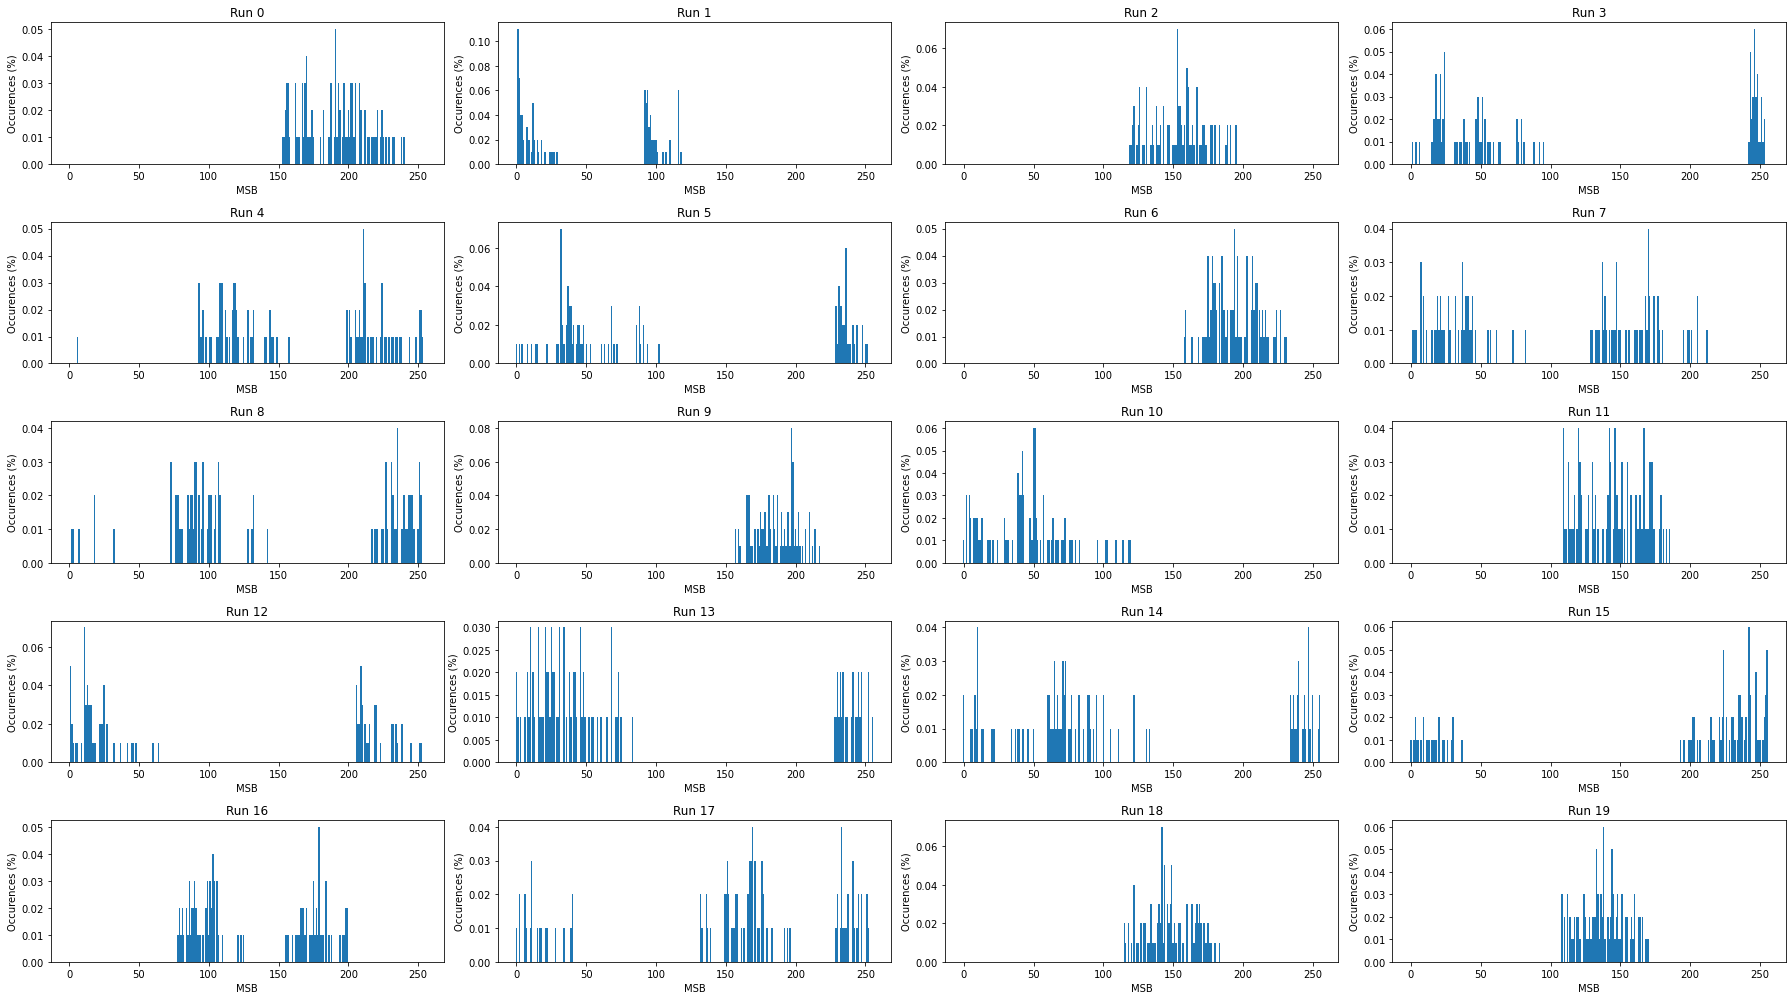

In [24]:
num = len(analyzed_runs)
ncols = 4
nrows = ceil(num/ncols)
x = list(range(256))

fig, axs = plt.subplots(nrows,ncols,figsize =(25, 14)) 
r,c = 0,0
for i, masks_info in enumerate(analyzed_runs):
    y = i_byte(masks_info,153)
    ax = axs[r][c]
    ax.bar(x, y, width = 1)
    ax.set_xlabel("MSB")
    ax.set_ylabel("Occurences (%)")
    ax.set_title(f"Run {i}")
    c+=1
    if c>=ncols:
        c = 0
        r +=1
fig.tight_layout()

## Residue bias
Furthermore, when we look at the same 20 runs we see that there is also bias in the residue classes modulo small primes. These plots show on the x-axis the prime and on the y-axis the number of residue classes that the masks "hit" for that run. The expected number of hits is marked in red.

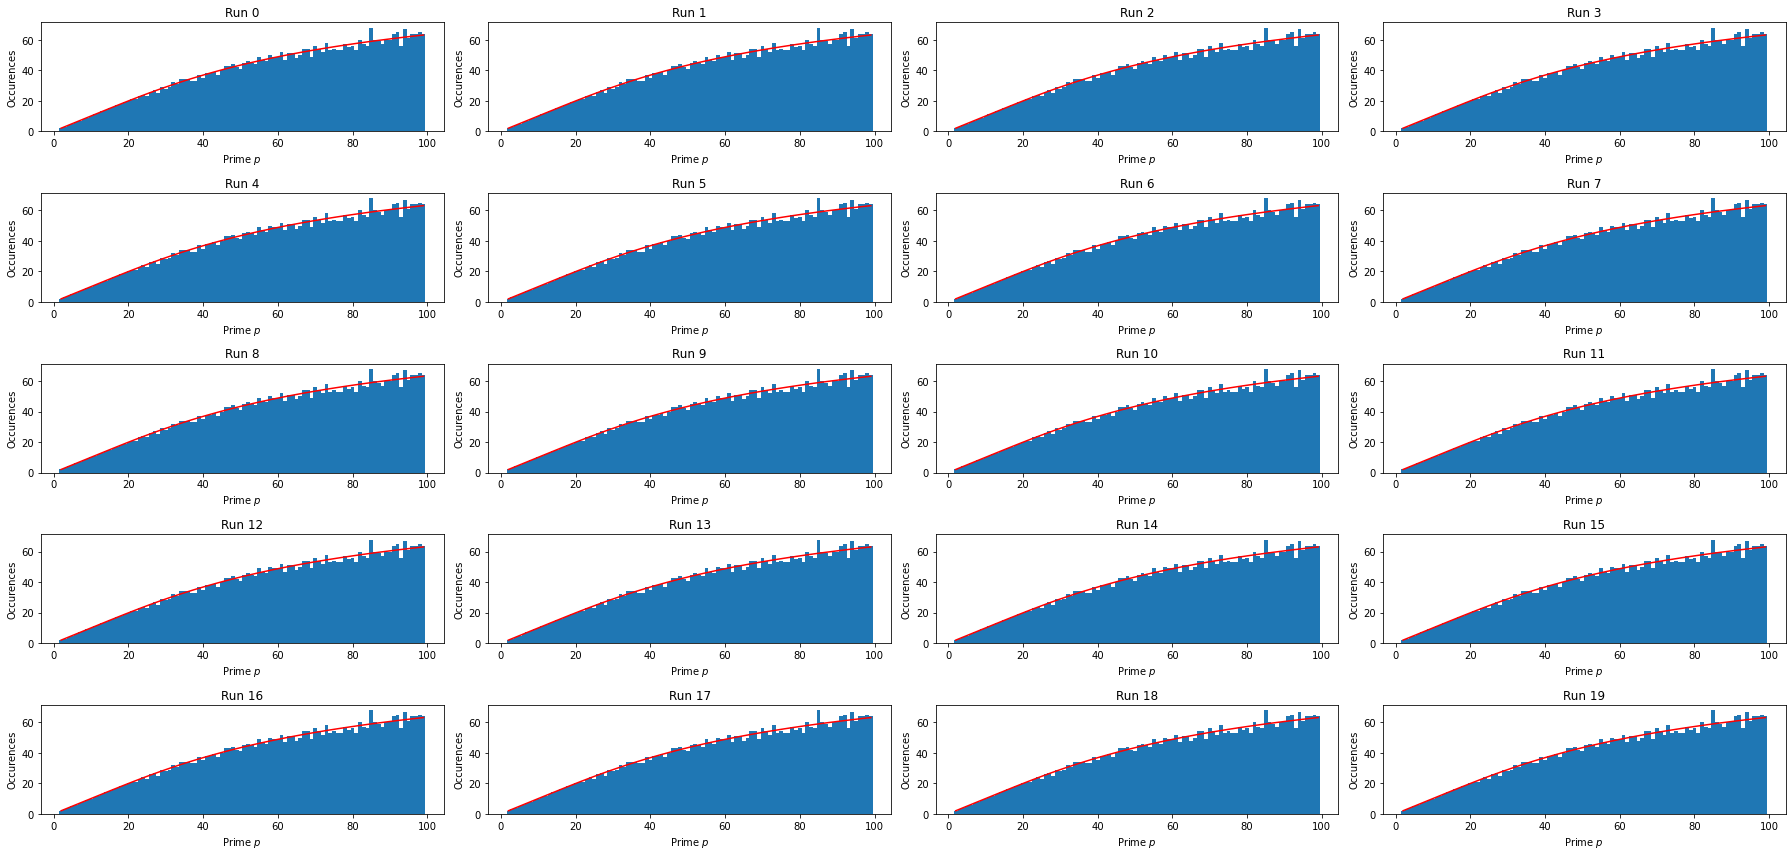

In [26]:
from math import factorial


def expected_residue_count(n,q):
    e = 0
    for r in range(1,q+1):
        s = 0
        for i in range(r):
            v1 = factorial(q)//factorial(q-r)
            v2 = factorial(r)//factorial(r-i)//factorial(i)
            s+=(-1)**i*v1*v2*(r-i)**n//factorial(r)
        assert s<=(q**n),(s,n,q,v1,v2)
        e+=r*s/(q**n)
    return e


small_divisors = list(range(2,100))

num = len(analyzed_runs)
ncols = 4
nrows = ceil(num/ncols)
x = small_divisors
expected = [expected_residue_count(len(analyzed_runs[0]),q) for q in small_divisors] # assumes all runs have the same number of executions

fig,axs = plt.subplots(nrows,ncols,figsize =(25, 12)) 
r,c = 0,0
for i, masks_info in enumerate(analyzed_runs):
    y = [len(set(([m%q for m,_,_,_ in masks]))) for q in small_divisors]
    ax = axs[r][c]
    ax.bar(x,y,width = 1)
    ax.plot(x,expected,color = "red")
    ax.set_xlabel("Prime $p$")
    ax.set_ylabel("Occurences")
    ax.set_title(f"Run {i}")
    c+=1
    if c>=ncols:
        c = 0
        r +=1

fig.tight_layout()

### Simulated bias for a\*r1+b\*r2+c
We had a hypothesis that the masks are of the form $ a*r_1+b*r_2+c $ where each run has a fixed $a, b, c$ but random $r_1$ and $r_2$ for each execution. The simulated results are shown below.

In [27]:
from random import randint

fake_masks = []
for _ in range(len(analyzed_runs)):
    a,b,c = randint(1,2**128),randint(1,2**128),randint(1,2**128)
    masks = []
    for _ in range(len(analyzed_runs[0])):
        r1,r2 = randint(1,2**32),randint(1,2**32)
        masks.append(a*r1+b*r2+c)
    fake_masks.append(masks)


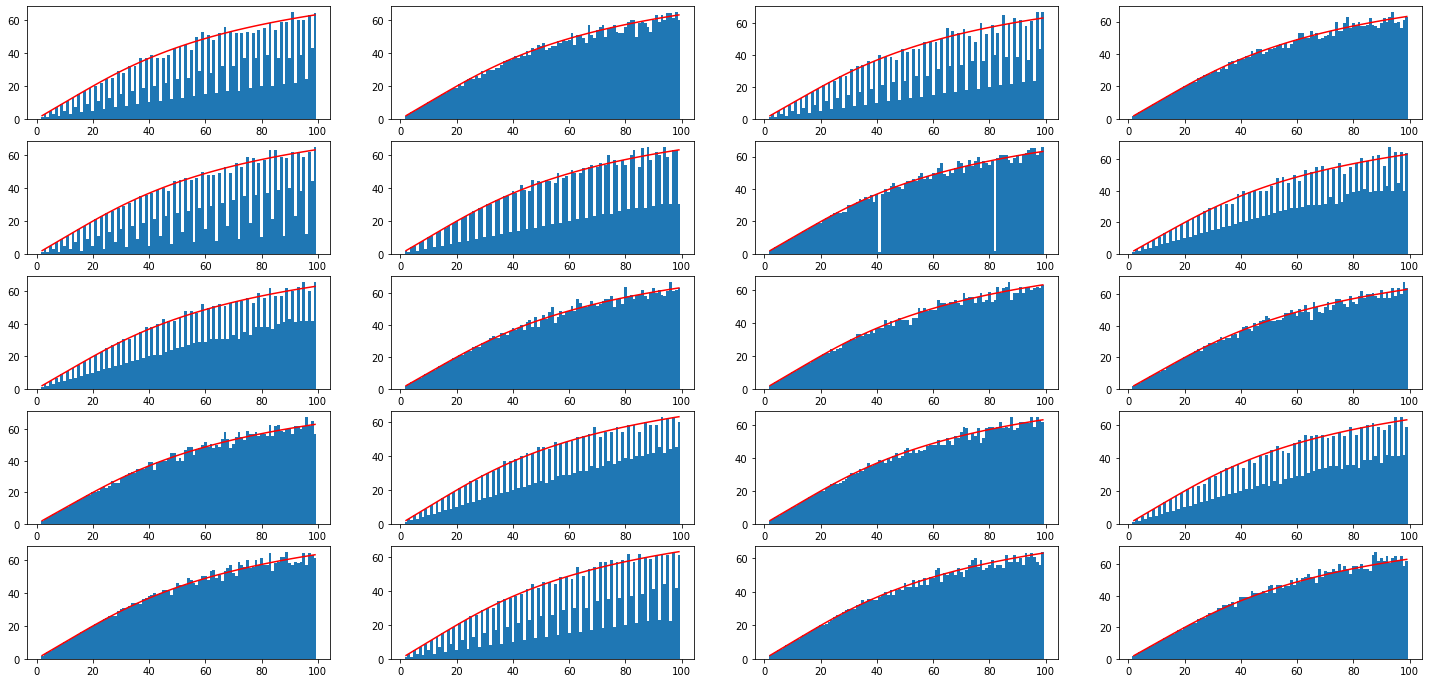

In [28]:
num = len(fake_masks)
ncols = 4
nrows = ceil(num/ncols)
x = small_divisors

fig,axs = plt.subplots(nrows,ncols,figsize =(25, 12)) 
r,c = 0,0
for masks in fake_masks:
    y = [len(set(([m%q for m in masks]))) for q in small_divisors]
    axs[r][c].bar(x,y,width = 1)
    axs[r][c].plot(x,expected,color = "red")
    c+=1
    if c>=ncols:
        c = 0
        r +=1